# Tutorial 2: Training a spiking neural network on a simple vision dataset

Friedemann Zenke (https://fzenke.net)

> For more details on surrogate gradient learning, please see: 
> Neftci, E.O., Mostafa, H., and Zenke, F. (2019). Surrogate Gradient Learning in Spiking Neural Networks.
> https://arxiv.org/abs/1901.09948

In Tutorial 1, we have seen how to train a simple multi-layer spiking neural network on a small synthetic dataset. In this tutorial, we will apply what we have learned so far to a slightly larger dataset.
Concretely, we will use the [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). 

In [69]:
"""2024-08-12 CS 세미나 피드백 정리
이 코드 상에서는 스파이크를 표현하는 다양한 방식 중, 첫번째 발생한 스파이크를 기준으로 입력 데이터를 처리하는 방식을 채택하였다.
-> Q. 이 방식이 무엇?
첫번째 발생한 스파이크가 빠르게 발생할 수록 스파이크의 농도가 짙은 것으로 표현
즉, firing2time 함수의 반환값은 스파이크가 언제 발생했는지에 대한 타임스텝 값을 나타냄
함수에서 스파이크가 발생하지 않으면 타임스탭은 100 즉, 시뮬레이션 시간동안 발생하지 않은 것으로 판단.

다음 해야될 것은 sparse 매트릭스에 대한 이해를 해야된다.
"""

'2024-08-12 CS 세미나 피드백 정리\n이 코드 상에서는 스파이크를 표현하는 다양한 방식 중, 첫번째 발생한 스파이크를 기준으로 입력 데이터를 처리하는 방식을 채택하였다.\n-> Q. 이 방식이 무엇?\n첫번째 발생한 스파이크가 빠르게 발생할 수록 스파이크의 농도가 짙은 것으로 표현\n즉, firing2time 함수의 반환값은 스파이크가 언제 발생했는지에 대한 타임스텝 값을 나타냄\n함수에서 스파이크가 발생하지 않으면 타임스탭은 100 즉, 시뮬레이션 시간동안 발생하지 않은 것으로 판단.\n\n다음 해야될 것은 sparse 매트릭스에 대한 이해를 해야된다.\n'

In [70]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn
import torchvision

In [71]:
torch.__version__

'2.1.2+cu121'

In [72]:
# The coarse network structure is dicated by the Fashion MNIST dataset. 
nb_inputs  = 28*28  # 입력 뉴런, 28x28 이미지 픽셀
nb_hidden  = 100    # 은닉층 뉴런
nb_outputs = 10     # 출력 뉴런, 0~9 넘버링된 패션 이미지

time_step = 1e-3    # 시간 단위 0.0001
nb_steps  = 100     # 시뮬레이션 시간, 100 시간 동안 시뮬레이션, 0.0001 x 100 총 0.1초 시뮬레이션

batch_size = 256    # 배치크기 지정

In [73]:
dtype = torch.float                 # 데이터 타입 지정

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")     
else:
    device = torch.device("cpu")

device

device(type='cuda')

In [74]:
# Here we load the Dataset
# MNIST 데이터 로딩
root = os.path.expanduser("~/data/datasets/torch/fashion-mnist")
train_dataset = torchvision.datasets.FashionMNIST(root, train=True, transform=None, target_transform=None, download=True)   # 훈련데이터 불러오기
test_dataset = torchvision.datasets.FashionMNIST(root, train=False, transform=None, target_transform=None, download=True)   # 테스트데이터 불러오기

In [75]:
train_dataset, test_dataset

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: /home/hadoop/data/datasets/torch/fashion-mnist
     Split: Train,
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: /home/hadoop/data/datasets/torch/fashion-mnist
     Split: Test)

In [76]:
# Standardize data
# x_train = torch.tensor(train_dataset.train_data, device=device, dtype=dtype)
x_train = np.array(train_dataset.data, dtype=float)
x_train = x_train.reshape(x_train.shape[0], -1)/255 # 데이터 0~1 표준 정규화
# x_test = torch.tensor(test_dataset.test_data, device=device, dtype=dtype)
x_test = np.array(test_dataset.data, dtype=float)
x_test = x_test.reshape(x_test.shape[0], -1)/255

# y_train = torch.tensor(train_dataset.train_labels, device=device, dtype=dtype)
# y_test  = torch.tensor(test_dataset.test_labels, device=device, dtype=dtype)
y_train = np.array(train_dataset.targets, dtype=int)
y_test  = np.array(test_dataset.targets, dtype=int)

In [77]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

(-0.5, 27.5, 27.5, -0.5)

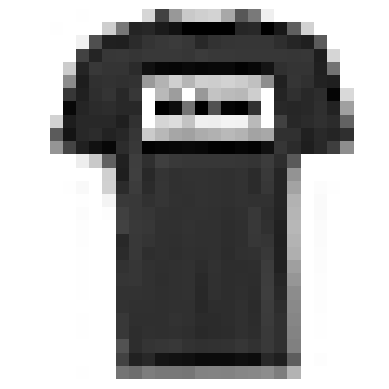

In [78]:
# Here we plot one of the raw data points as an example
data_id = 1
plt.imshow(x_train[data_id].reshape(28,28), cmap=plt.cm.gray_r)
plt.axis("off")

Since we are working with spiking neural networks, we ideally want to use a temporal code to make use of spike timing. To that end, we will use a spike latency code to feed spikes to our network.

In [79]:
def current2firing_time(x, tau=20, thr=0.2, tmax=1.0, epsilon=1e-7):
    """LIF 뉴런 모델에서 입력에 따라 첫번째 스파이크가 발생되는 시간 계산

    Args:
    x -- The "current" values, 현재 전류값

    Keyword args:
    tau -- The membrane time constant of the LIF neuron to be charged, 뉴런의 막전위가 증가되는 속도, 최소 속도 보장
    thr -- The firing threshold value, 스파이크 임계값, 스파이크 발생
    tmax -- The maximum time returned, 반환 최대 값, 시뮬레이션 step 값
    epsilon -- A generic (small) epsilon > 0, 0보다 큰 값으로 설정, 일반적으로 Division Error을 발생시키지 않기 위해 사용
    이 코드 상에서 최소값이 0을 방지하기 위해서 사용

    Returns:
    Time to first spike for each "current" x
    x에 대한 첫번째 스파이크 발생 시간
    """
    idx = x < thr
    x = np.clip(x, thr + epsilon, 1e9) # x: 입력값, thr+epsilon: 입력값이 가질 수 있는 최소값, 1e9: 입력값이 가질 수 있는 최대값
    T = tau * np.log(x / (x - thr))
    T[idx] = tmax

    # 값이 임계치보다 큰 인덱스 저장
    # 값을 특정 범위 (임계값 + 1e-7) ~ 1000000000.0
    # 로그 그래프 상으로 값을 표현
    # 로그 그래프 상으로 표현한 값에서 임계치보다 큰 값을 가지는 값은 최대값으로 지정

    return T

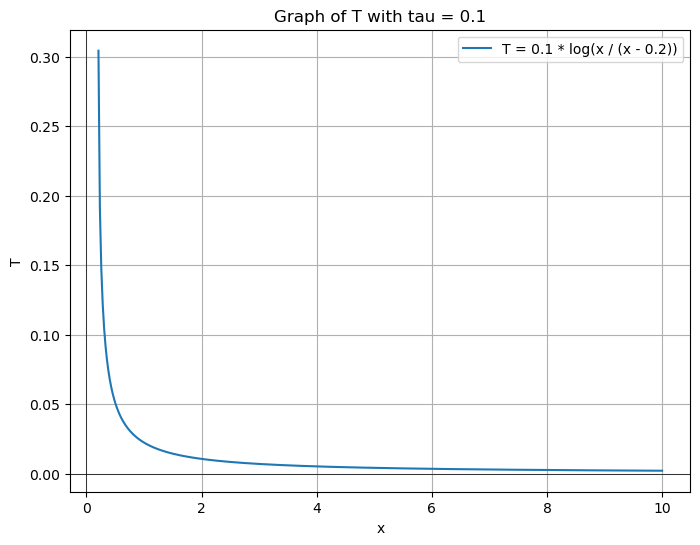

In [80]:
import numpy as np
import matplotlib.pyplot as plt

# 그래프를 그리는 함수
def plot_graph(tau):
    x = np.linspace(0.21, 10, 400)  # x의 범위 설정 (0.21부터 시작해 0으로 나누는 오류를 피함)
    T = tau * np.log(x / (x - 0.2))  # 주어진 함수

    plt.figure(figsize=(8, 6))
    plt.plot(x, T, label=f'T = {tau} * log(x / (x - 0.2))')
    plt.title(f"Graph of T with tau = {tau}")
    plt.xlabel("x")
    plt.ylabel("T")
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.legend()
    plt.grid(True)
    plt.show()

# tau 값을 수동으로 설정하고 그래프를 출력
tau = 0.1  # 원하는 tau 값으로 변경 가능
plot_graph(tau)

In [81]:
current2firing_time(x_train[0])

array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.  

In [82]:
current2firing_time(x_train).shape

(60000, 784)

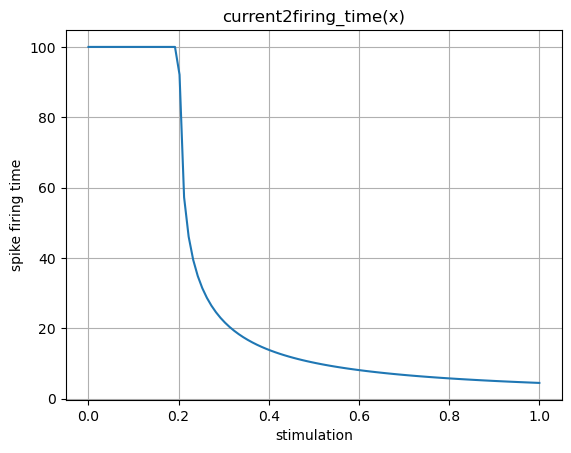

(100,)


0

In [83]:
import matplotlib.pyplot as plt
import numpy as np

# 2. x 축에 사용할 값 생성하기
x = np.linspace(0.0, 1.0, 100)  # -10에서 10까지 400개의 점 생성

# 4. 함수의 반환값 계산하기
y = current2firing_time(x, tau=20, thr=0.2, tmax=100, epsilon=1e-7)

# 5. 그래프 그리기
plt.plot(x, y)
plt.xlabel('stimulation')
plt.ylabel('spike firing time')
plt.title('current2firing_time(x)')
plt.grid(True)
plt.show()

print(y.shape)
np.argmax(y)

In [84]:
x = x_train[0:3]
print("x.shape:", x.shape)

output = current2firing_time(x, tau=20.0, thr=0.2, tmax=100)
print("output.shape:", output.shape)

output

x.shape: (3, 784)
output.shape: (3, 784)


array([[100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.]])

In [85]:
print("output:", output[2])
c = output[2] < 100.0
print("c:", c)
output[2][c]

output: [100.         100.         100.         100.         100.
 100.         100.         100.         100.         100.
  11.3198401  100.         100.         100.         100.
 100.         100.         100.          17.32837804 100.
 100.         100.         100.         100.         100.
 100.         100.         100.         100.         100.
 100.         100.         100.         100.         100.
 100.         100.          14.26699776   5.50363819   5.72114753
   6.4503205    6.70711084   6.985411     6.40943791   6.13726263
   5.24728529   8.89935102  18.32581464 100.         100.
 100.         100.         100.         100.         100.
 100.         100.         100.         100.         100.
 100.         100.         100.         100.         100.
  18.32581464  22.23715031   5.92185102   5.14090206   4.60450035
   4.46287103   4.82324114   5.11498051   7.85613422  27.72588722
  20.29461609 100.         100.         100.         100.
 100.         100.         100. 

array([11.3198401 , 17.32837804, 14.26699776,  5.50363819,  5.72114753,
        6.4503205 ,  6.70711084,  6.985411  ,  6.40943791,  6.13726263,
        5.24728529,  8.89935102, 18.32581464, 18.32581464, 22.23715031,
        5.92185102,  5.14090206,  4.60450035,  4.46287103,  4.82324114,
        5.11498051,  7.85613422, 27.72588722, 20.29461609, 16.43960105,
       26.87469493, 16.43960105,  5.85339228,  5.33002501,  5.14090206,
        5.59478438,  7.79532397, 36.16577542, 15.8985975 , 24.64287363,
       20.74486685, 17.0210042 , 36.16577542, 39.96191804, 17.6477836 ,
       12.78159919, 22.78868566, 48.31827557, 22.23715031, 14.92139164,
       23.98833976, 22.78868566, 17.0210042 , 20.29461609, 20.29461609,
       28.64207794, 33.16456153, 23.98833976, 19.0620941 , 20.29461609,
       15.15371403, 24.64287363, 21.71417768, 17.32837804, 21.71417768,
       20.29461609, 19.0620941 , 19.0620941 , 19.0620941 , 19.0620941 ,
       19.86503546, 15.39374515, 22.23715031, 17.0210042 , 15.15

In [86]:
def sparse_data_generator(X, y, batch_size, nb_steps, nb_units, shuffle=True):
    """ This generator takes datasets in analog format and generates spiking network input as sparse tensors. 
    이 제너레이트는 기본 데이터셋을 SNN에 맞게 변환시켜줍니다.

    Args:
        X: The data ( sample x event x 2 ) the last dim holds (time, neuron) tuples
        y: The labels
        X: 입력데이터, 마지막 차원은 (time, neuron) 이다.
        y: 출력데이터, 라벨데이터
    """

    """
    labels: 라벨 배열
    number_of_batches: 배치 크기
    sample_index: 입력데이터 인덱스 [0, 1, 2, ...]
    """
    labels_ = np.array(y, dtype=int)            # 라벨 상수 생성
    number_of_batches = len(X) // batch_size    # 배치 크기 생성
    sample_index = np.arange(len(X))            # 데이터의 인덱스로 쓰일 값

    # compute discrete firing times
    # 이산 스파이크 시간 계산
    tau_eff = 20e-3 / time_step

    # 값이 임계치보다 큰 인덱스 저장
    # 값을 특정 범위 (임계값 + 1e-7) ~ 1000000000.0
    # 로그 그래프 상으로 값을 표현
    # 로그 그래프 상으로 표현한 값에서 임계치보다 큰 값을 가지는 값은 최대값으로 지정
    # 스파이크가 발생한 시간(time step)을 반환
    firing_times = np.array(current2firing_time(X, tau=tau_eff, tmax=nb_steps), dtype=int)
    
    unit_numbers = np.arange(nb_units)

    # 데이터 셔플
    if shuffle:
        np.random.shuffle(sample_index)

    total_batch_count = 0
    counter = 0
    while counter < number_of_batches:
        batch_index = sample_index[batch_size * counter:batch_size * (counter+1)]

        coo = [ [] for i in range(3) ] # 배치, 시간, 유닛
        for bc, idx in enumerate(batch_index):
            # time step 값이 100 이하여야지 스파이크 발생됨
            c = firing_times[idx] < nb_steps    # 100이하일 경우 True, 100이면 False
            times, units = firing_times[idx][c], unit_numbers[c]    # 100 이하인 경우만 times에 저장, units에 인덱스(뉴런 번호) 저장

            batch = [bc for _ in range(len(times))]
            # extend: 여러 요소를 1차원으로 변환해 끝에 입력
            # append: 차원을 유지시켜 그대로 끝에 입력
            coo[0].extend(batch) # 스파이크 발생한 기록의 배치 번호를 입력
            coo[1].extend(times) # 스파이크 발생 시간 입력
            coo[2].extend(units) # 스파이크가 발생한 유닛 번호 입력
            
            # 생성된 coo 모양 coo[[배치 내의 데이터 번호], [스파이크 발생 시간 step], [스파이크 발생 유닛 번호]]

        i = torch.LongTensor(coo).to(device)    # coo(배치(0~시간 개수), 시간(100 이하), 유닛(100 이하인 뉴런 번호))이 저장된 
        v = torch.FloatTensor(np.ones(len(coo[0]))).to(device) # 1의 값을 가지며, coo[0]와 동일한 크기의 실수형 텐서 생성
    
        # 희소행렬(행렬상의 0을 생략하는 행렬) 생성: (비영향 요소의 위치, 기본 행렬, 희소 행렬 전체 크기)
        # 비영향 요소: 0이 아닌 요소
        X_batch = torch.sparse.FloatTensor(i, v, torch.Size([batch_size, nb_steps, nb_units])).to(device)
        y_batch = torch.tensor(labels_[batch_index], device=device)

        # 제너레이터 생성, yield를 통해 값이 사용된 후 다시 함수로 넘어와 작업 수행 후 yield에서 호출 대기
        yield X_batch.to(device=device), y_batch.to(device=device)

        counter += 1

In [87]:
20e-3 / time_step

20.0

In [88]:
generate_test = sparse_data_generator(x_train, y_train, batch_size, nb_steps, nb_inputs)
generate_test

<generator object sparse_data_generator at 0x7f892ad9f140>

In [89]:
test_value = next(generate_test)

In [90]:
test_value[0][0].shape

torch.Size([100, 784])

In [91]:
test_value[0][0]

tensor(indices=tensor([[ 13,   8,  10,   8,   8,   7,  12,  23,   5,   6,  11,
                          6,  14,  10,  10,   6,  30,   5,  48,   4,  10,   7,
                          4,   6,  16,  26,   4,   5,  30,   8,   6,   7,   8,
                          8,  15,   8,  16,  31,   4,   4,  20,   6,  34,  25,
                          4,   8,   5,   6,  22,   4,   5,   6,   5,   4,   8,
                          4,  10,   4,  37,  10,   8,   5,   5,   5,   8,  15,
                         57,   5,   5,   4,   5,   5,   4,   4,   7,  19,  14,
                         13,   5,   5,   5,   4,  21,   6,   6,   5,   5,  11,
                          7,   4,   5,   5,   4,  30,   5,   7,   8,   7,   5,
                          5,   7,  19,   4,   6,   9,   4,   5,   4,   7,   9,
                          9,  10,  10,   8,   6,   4,   6,  11,   4,   5,   4,
                         23,   7,   9,   6,   7,   8,   6,   6,  10,   8,   4,
                          5,   4,   8,   6,   7,   6

In [92]:
test_value[0].shape

torch.Size([256, 100, 784])

In [93]:
test_value[0]

tensor(indices=tensor([[  0,   0,   0,  ..., 255, 255, 255],
                       [ 13,   8,  10,  ...,  33,  12,   8],
                       [ 16,  17,  18,  ..., 771, 772, 773]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       device='cuda:0', size=(256, 100, 784), nnz=83274, layout=torch.sparse_coo)

In [94]:
print(test_value[1].shape)
test_value[1]

torch.Size([256])


tensor([5, 5, 0, 8, 9, 7, 5, 0, 4, 5, 3, 5, 5, 6, 8, 0, 3, 0, 1, 0, 0, 1, 2, 5,
        3, 1, 8, 5, 1, 8, 2, 5, 9, 1, 2, 2, 2, 0, 5, 9, 6, 8, 5, 8, 0, 1, 1, 3,
        7, 5, 1, 0, 0, 0, 7, 4, 1, 2, 6, 3, 1, 2, 4, 9, 1, 1, 6, 2, 8, 7, 1, 9,
        5, 7, 8, 5, 7, 7, 1, 1, 3, 0, 6, 0, 5, 2, 0, 3, 9, 0, 2, 9, 5, 0, 5, 6,
        1, 9, 4, 3, 7, 6, 3, 9, 0, 4, 1, 1, 4, 9, 2, 9, 4, 3, 1, 3, 2, 2, 1, 4,
        6, 5, 2, 8, 7, 3, 6, 2, 1, 4, 7, 4, 1, 3, 9, 1, 2, 6, 1, 5, 8, 6, 0, 6,
        9, 9, 8, 6, 6, 3, 0, 3, 0, 2, 2, 0, 7, 1, 5, 0, 0, 8, 8, 9, 3, 1, 2, 4,
        8, 0, 5, 5, 1, 0, 2, 7, 7, 4, 9, 1, 2, 1, 0, 9, 9, 6, 5, 8, 8, 3, 1, 2,
        9, 1, 6, 3, 8, 1, 9, 7, 0, 7, 9, 2, 4, 6, 5, 8, 1, 5, 5, 4, 5, 0, 7, 0,
        8, 4, 6, 6, 0, 3, 6, 7, 2, 5, 1, 0, 3, 3, 9, 9, 1, 7, 2, 4, 2, 3, 1, 5,
        8, 9, 2, 8, 7, 7, 8, 9, 6, 9, 4, 8, 3, 4, 9, 1], device='cuda:0')

### Setup of the spiking network model

In [95]:
tau_mem = 10e-3 # 막전위 변화율, 전류
tau_syn = 5e-3  # 시냅스 변화율, 전달 스파이크

alpha   = float(np.exp(-time_step/tau_syn)) # 알파 파라미터 지정
beta    = float(np.exp(-time_step/tau_mem)) # 베타 파라미터 지정

In [96]:
weight_scale = 7 * (1.0 - beta) # this should give us some spikes to begin with

# 입력층 -> 은닉층 가중치 초기화
w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale / np.sqrt(nb_inputs))

# 은닉층 -> 출력층 가중치 초기화
w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale / np.sqrt(nb_hidden))

print(w1.shape, w2.shape)
print("init done")

torch.Size([784, 100]) torch.Size([100, 10])
init done


In [97]:
# 스파이크 발생을 그래프로 표현, (3,5) 총 15개를 동시에 확인 가능
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5):
    gs=GridSpec(*dim)

    if spk is not None:
        dat = 1.0 * mem
        dat[spk > 0.0] = spike_height   # 스파이크 발생 확인, 높이 5로 지정
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()

    for i in range(np.prod(dim)):
        if i==0:
            a0 = ax = plt.subplot(gs[i])
        else:
            ax = plt.subplot(gs[i], sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")

We can now run this code and plot the output layer "membrane potentials" below. As desired, these potentials do not have spikes riding on them.

## Training the network

In [98]:
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """
    
    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """ctx: 상태정보나 환경정보, 자동 미분을 처리해주는 커스텀 연산자
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """ctx: 상태정보나 환경정보, 자동 미분을 처리해주는 커스텀 연산자
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input / (SurrGradSpike.scale * torch.abs(input) + 1.0)**2
        return grad
    
# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
# SurrgateGradient 설정, 서로게이 기울기를 스파이크 함수로 지정
spike_fn  = SurrGradSpike.apply

In [99]:
def run_snn(inputs):
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

    mem_rec = []
    spk_rec = []

    # Compute hidden layer activity
    for t in range(nb_steps):
        mthr = mem - 1.0
        out = spike_fn(mthr)
        rst = out.detach() # We do not want to backprop through the reset

        new_syn = alpha*syn +h1[:,t]
        new_mem = (beta*mem +syn)*(1.0-rst)

        mem_rec.append(mem)
        spk_rec.append(out)
        
        mem = new_mem
        syn = new_syn

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(nb_steps):
        new_flt = alpha * flt +h2[:,t]
        new_out = beta*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

In [100]:
def train(x_data, y_data, lr=2e-3, nb_epochs=10):
    params = [w1, w2]
    optimizer = torch.optim.Adam(params, lr=lr, betas=(0.9, 0.999))

    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()
    
    loss_hist = []
    for e in range(nb_epochs):
        local_loss = []
        for x_local, y_local in sparse_data_generator(x_data, y_data, batch_size, nb_steps, nb_inputs):
            output, _ = run_snn(x_local.to_dense())
            m, _ = torch.max(output,1)
            log_p_y = log_softmax_fn(m)
            loss_val = loss_fn(log_p_y, y_local)

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            local_loss.append(loss_val.item())

        mean_loss = np.mean(local_loss)
        print("Epoch %i: loss=%.5f"%(e+1, mean_loss))
        loss_hist.append(mean_loss)
        
    return loss_hist
        
        
def compute_classification_accuracy(x_data, y_data):
    """ Computes classification accuracy on supplied data in batches. 
    정확도 계산"""
    accs = []
    for x_local, y_local in sparse_data_generator(x_data, y_data, batch_size, nb_steps, nb_inputs, shuffle=False):
        output,_ = run_snn(x_local.to_dense())
        m,_= torch.max(output,1) # max over time
        _,am=torch.max(m,1)      # argmax over output units
        tmp = np.mean((y_local==am).detach().cpu().numpy()) # compare to labels
        accs.append(tmp)

    return np.mean(accs)

In [101]:
loss_hist = train(x_train, y_train, lr=2e-4, nb_epochs=30)

Epoch 1: loss=0.87151
Epoch 2: loss=0.53561
Epoch 3: loss=0.47312
Epoch 4: loss=0.44296
Epoch 5: loss=0.42672
Epoch 6: loss=0.40715
Epoch 7: loss=0.39099
Epoch 8: loss=0.38245
Epoch 9: loss=0.36880
Epoch 10: loss=0.36012
Epoch 11: loss=0.35096
Epoch 12: loss=0.34364
Epoch 13: loss=0.33935
Epoch 14: loss=0.33239
Epoch 15: loss=0.32638
Epoch 16: loss=0.32035
Epoch 17: loss=0.31507
Epoch 18: loss=0.31022
Epoch 19: loss=0.30474
Epoch 20: loss=0.29878
Epoch 21: loss=0.29516
Epoch 22: loss=0.29081
Epoch 23: loss=0.28886
Epoch 24: loss=0.28260
Epoch 25: loss=0.27776
Epoch 26: loss=0.27533
Epoch 27: loss=0.27197
Epoch 28: loss=0.26675
Epoch 29: loss=0.26689
Epoch 30: loss=0.26272


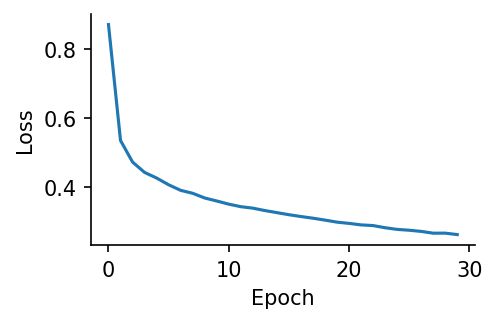

In [102]:
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()

In [103]:
print("Training accuracy: %.3f"%(compute_classification_accuracy(x_train,y_train)))
print("Test accuracy: %.3f"%(compute_classification_accuracy(x_test,y_test)))

Training accuracy: 0.909
Test accuracy: 0.865


In [104]:
# 제너레이터를 호출하였지만 return 문에 의해 하나의 배치만 반환하고 종료됨
def get_mini_batch(x_data, y_data, shuffle=False):
    for ret in sparse_data_generator(x_data, y_data, batch_size, nb_steps, nb_inputs, shuffle=shuffle):
        return ret 

In [105]:
get_mini_batch(x_test, y_test)

(tensor(indices=tensor([[  0,   0,   0,  ..., 255, 255, 255],
                        [ 18,  11,  17,  ...,  21,   6,  19],
                        [241, 249, 268,  ..., 777, 778, 779]]),
        values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
        device='cuda:0', size=(256, 100, 784), nnz=85745, layout=torch.sparse_coo),
 tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
         1, 4, 6, 0, 9, 3, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 7, 6, 7, 2, 1,
         2, 2, 4, 4, 5, 8, 2, 2, 8, 4, 8, 0, 7, 7, 8, 5, 1, 1, 2, 3, 9, 8, 7, 0,
         2, 6, 2, 3, 1, 2, 8, 4, 1, 8, 5, 9, 5, 0, 3, 2, 0, 6, 5, 3, 6, 7, 1, 8,
         0, 1, 4, 2, 3, 6, 7, 2, 7, 8, 5, 9, 9, 4, 2, 5, 7, 0, 5, 2, 8, 6, 7, 8,
         0, 0, 9, 9, 3, 0, 8, 4, 1, 5, 4, 1, 9, 1, 8, 6, 2, 1, 2, 5, 1, 0, 0, 0,
         1, 6, 1, 6, 2, 2, 4, 4, 1, 4, 5, 0, 4, 7, 9, 3, 7, 2, 3, 9, 0, 9, 4, 7,
         4, 2, 0, 5, 2, 1, 2, 1, 3, 0, 9, 1, 0, 9, 3, 6, 7, 9, 9, 4, 4, 7, 1, 2,
         1, 6, 3, 2, 8, 3

In [106]:
x_batch, y_batch = get_mini_batch(x_test, y_test)
output, other_recordings = run_snn(x_batch.to_dense())
mem_rec, spk_rec = other_recordings

In [107]:
mem_rec[0:5].shape

torch.Size([5, 100, 100])

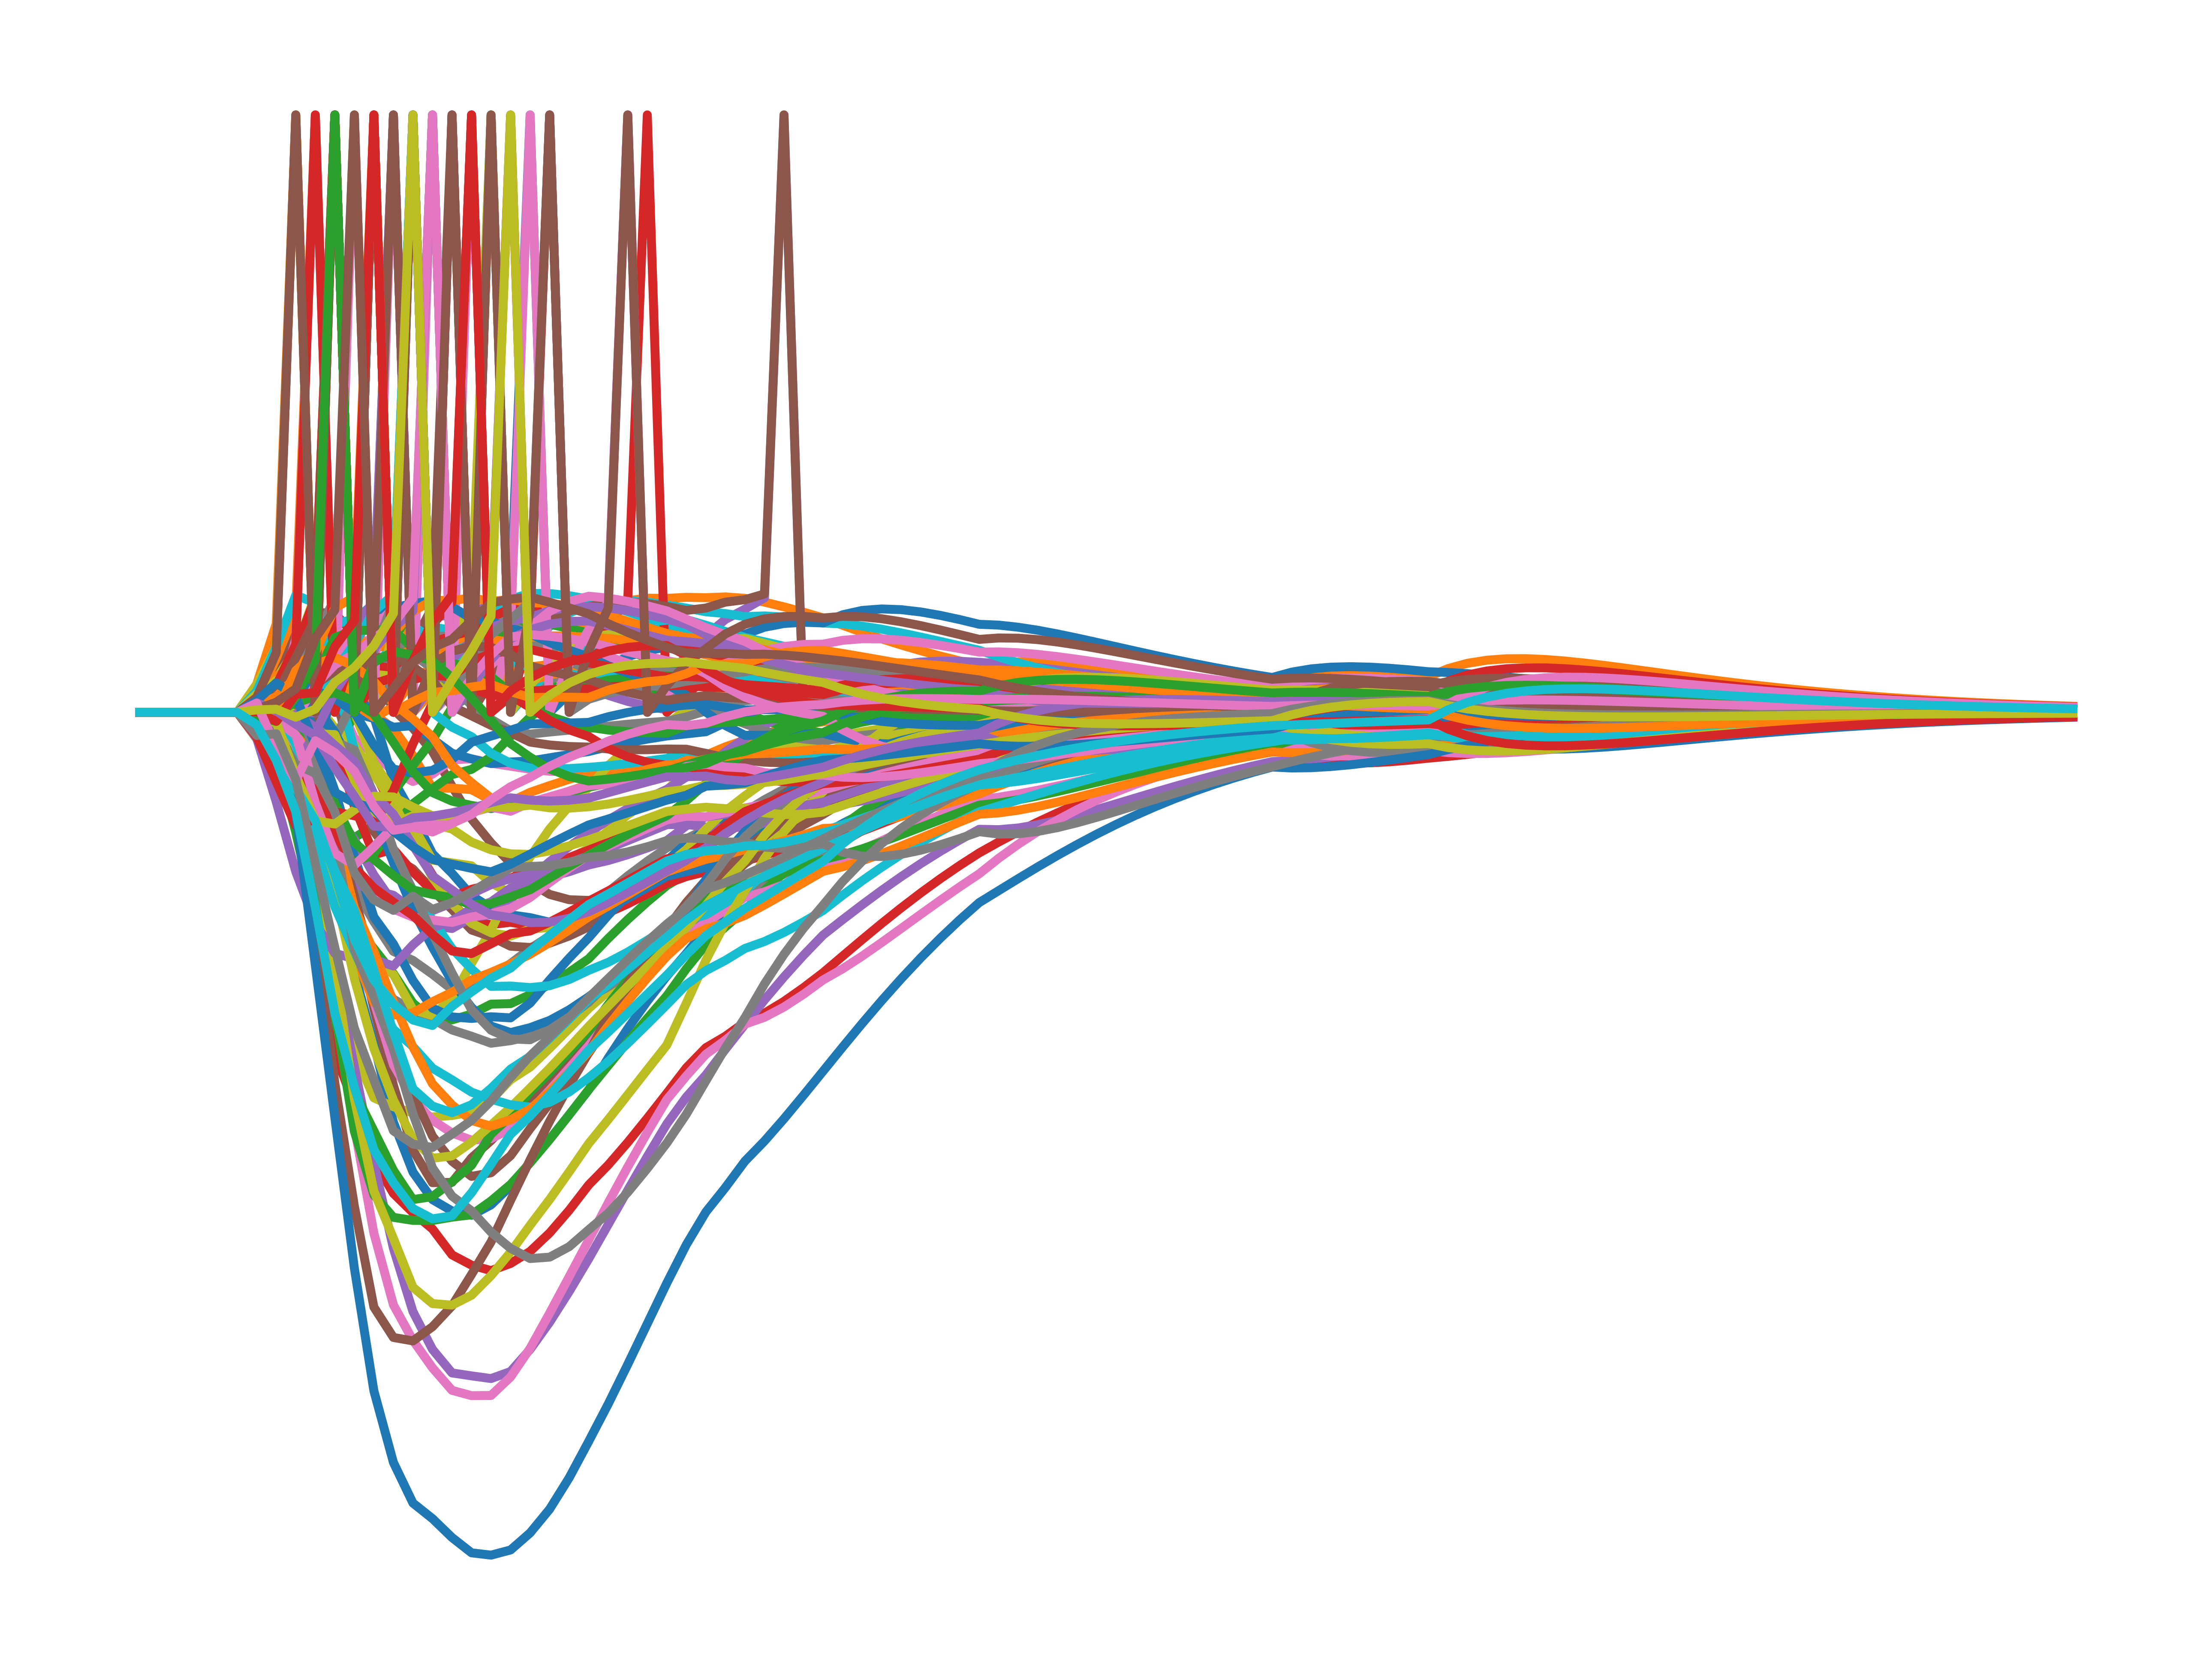

In [108]:
fig=plt.figure(dpi=1000)
plot_voltage_traces(mem_rec, spk_rec, dim=(1, 1))

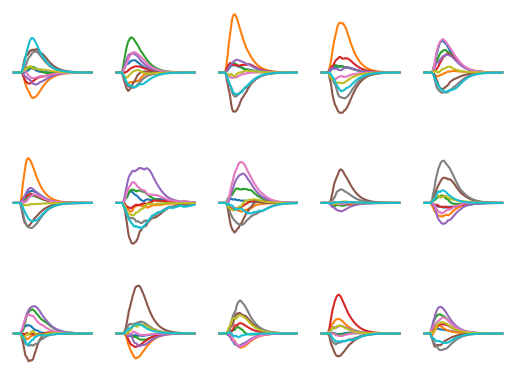

In [109]:
fig=plt.figure(dpi=100)
plot_voltage_traces(output)

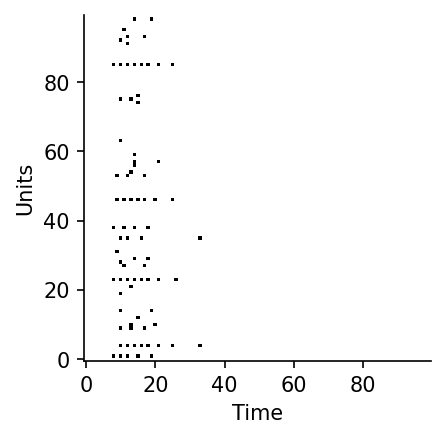

In [110]:
# Let's plot the hiddden layer spiking activity for some input stimuli

nb_plt = 1
gs = GridSpec(1,nb_plt)
fig= plt.figure(figsize=(7,3),dpi=150)
for i in range(nb_plt):
    plt.subplot(gs[i])
    plt.imshow(spk_rec[i].detach().cpu().numpy().T,cmap=plt.cm.gray_r, origin="lower" )
    if i==0:
        plt.xlabel("Time")
        plt.ylabel("Units")

    sns.despine()

In conclusion, we see that already this simple spiking network solves the classification problem with ~85% accuracy, and there is plenty of room left for tweaking. However, the hidden layer activities do not look very biological. Although the network displays population sparseness in that only a subset of neurons are active at any given time, the individual neurons' firing rates are pathologically high. This pathology is not too surprising since we have not incentivized low activity levels in any way. We will create such an incentive to address this issue by activity regularization in one of the next tutorials.

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.